In [25]:
import LibsControl
import numpy
import matplotlib.pyplot as plt


#load dynamics from log file
def load_from_file(file_name, dt):
    v = numpy.loadtxt(file_name)

    #u = numpy.array(v[:, 1:3])
    u = numpy.array(v[:, 3:5])
    x = numpy.array(v[:, 5:7])

    t = numpy.arange(x.shape[0])*dt
    
    return u, x, t

def difference(x):
    #add velocity terms
    x_pad = numpy.zeros((1, x.shape[1]))
    x_tmp = numpy.concatenate([x_pad, x], axis=0)

    #estimate velocity term
    dx = x_tmp[1:, :]  - x_tmp[0:-1, :]

    return dx

def state_augmentation(x):   
    #zero initial conditions
    x_aug = x - x[0]

    vel = difference(x_aug[:, 0:2])

    x_aug = numpy.concatenate([x_aug, vel], axis=1)

    return x_aug



def plot_results(t_result, u_result, x_ref, x_pred, steps_start = 0 , steps_end = -1):

    plt.clf()

    axis_count = 4
    if x_ref.shape[1] == 4:
        axis_count+= 2

    fig, axs = plt.subplots(axis_count, 1, figsize=(8, 2*5))


    u_result*= 60.0/(2.0*numpy.pi)


    axs[0].plot(t_result[steps_start:steps_end], u_result[steps_start:steps_end, 0], color="purple")
    axs[0].set_xlabel("time [s]")
    axs[0].set_ylabel("control forward")
    axs[0].grid()

    axs[1].plot(t_result[steps_start:steps_end], u_result[steps_start:steps_end, 1], color="purple")
    axs[1].set_xlabel("time [s]")
    axs[1].set_ylabel("control turn")
    axs[1].grid()


    axs[2].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 0], label="ground truth", color="red")
    axs[2].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 0], label="prediction", color="blue")
    axs[2].set_xlabel("time [s]")
    axs[2].set_ylabel("distance [mm]")
    axs[2].legend()
    axs[2].grid()

    axs[3].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 1]*180.0/numpy.pi, color="red")
    axs[3].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 1]*180.0/numpy.pi, color="blue")
    axs[3].set_xlabel("time [s]")
    axs[3].set_ylabel("angle [deg]")
    axs[3].grid()


    if axis_count == 6:
        axs[4].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 2], label="ground truth", color="red")
        axs[4].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 2], label="prediction", color="blue")
        axs[4].set_xlabel("time [s]")
        axs[4].set_ylabel("distance velocity")
        axs[4].legend()
        axs[4].grid()

        axs[5].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 3]*180.0/numpy.pi, color="red")
        axs[5].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 3]*180.0/numpy.pi, color="blue")
        axs[5].set_xlabel("time [s]")
        axs[5].set_ylabel("angle velocity")
        axs[5].grid()
        
    

    #fig.legend()


def matrix_to_c(name, x, eps = 10**-10):

    x_tmp = x.copy()

    x_tmp[numpy.where(numpy.abs(x_tmp) < eps)] = 0.0

    result_str = ""

    result_str+= "float " + name + "[] = {\n"
    for m in range(x.shape[0]):
        result_str+= "\t\t"
        for n in range(x.shape[1]):
            result_str+= str(numpy.float32(x_tmp[m][n]))
            if m == x.shape[0]-1 and n == x.shape[1]-1:
                result_str+= " "
            else:
                result_str+= ", "
       
        if m != x.shape[0]-1:
            result_str+= "\n"

    result_str+= "};\n"

    return result_str


In [26]:
#obtain model
dt = 1.0/250.0
u_result, x_result, t_result = load_from_file("./data/run_4.log", dt)


#normalise speed

x_ref = state_augmentation(x_result.copy())

    


#identification
#a_est, b_est = LibsControl.rls_identification(u_result, x_ref)
a_est, b_est = LibsControl.krls_identification(u_result, x_ref)


c_est = numpy.eye(a_est.shape[0])
    


print("mat_a = \n", a_est, "\n\n")
print("mat_b = \n", b_est, "\n\n")
print("mat_c = \n", c_est, "\n\n")
print("poles = \n")
print(numpy.linalg.eigvals(a_est))


#symmetrise model (optional) - fix imperfection in identification
a_est[0, 0] = 1.0
a_est[1, 1] = 1.0
#a_est[numpy.abs(a_est) < 10**-3] = 0.0


print("symmetrised model\n")
print("mat_a = \n", a_est, "\n\n")
print("mat_b = \n", b_est, "\n\n")

n_steps  = u_result.shape[0]
n_inputs = u_result.shape[1]
n_states = x_ref.shape[1]


mat_a = 
 [[ 9.99953900e-01 -9.14109214e-04  6.28150617e-01  1.55748836e+00]
 [ 6.58192668e-08  9.99881780e-01 -8.24644332e-04  7.70498464e-01]
 [-4.63025086e-05 -9.09797449e-04  6.28129718e-01  1.56193598e+00]
 [ 9.12424366e-08 -1.18716407e-04 -9.05235626e-04  7.71271114e-01]] 


mat_b = 
 [[ 5.20999575 -0.54655861]
 [ 0.01161065  0.0891618 ]
 [ 5.21008925 -0.54879925]
 [ 0.01276718  0.08895179]] 


mat_c = 
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] 


poles = 

[0.63888803 0.99986897 0.9995091  0.76097041]
symmetrised model

mat_a = 
 [[ 1.00000000e+00 -9.14109214e-04  6.28150617e-01  1.55748836e+00]
 [ 6.58192668e-08  1.00000000e+00 -8.24644332e-04  7.70498464e-01]
 [-4.63025086e-05 -9.09797449e-04  6.28129718e-01  1.56193598e+00]
 [ 9.12424366e-08 -1.18716407e-04 -9.05235626e-04  7.71271114e-01]] 


mat_b = 
 [[ 5.20999575 -0.54655861]
 [ 0.01161065  0.0891618 ]
 [ 5.21008925 -0.54879925]
 [ 0.01276718  0.08895179]] 




<Figure size 640x480 with 0 Axes>

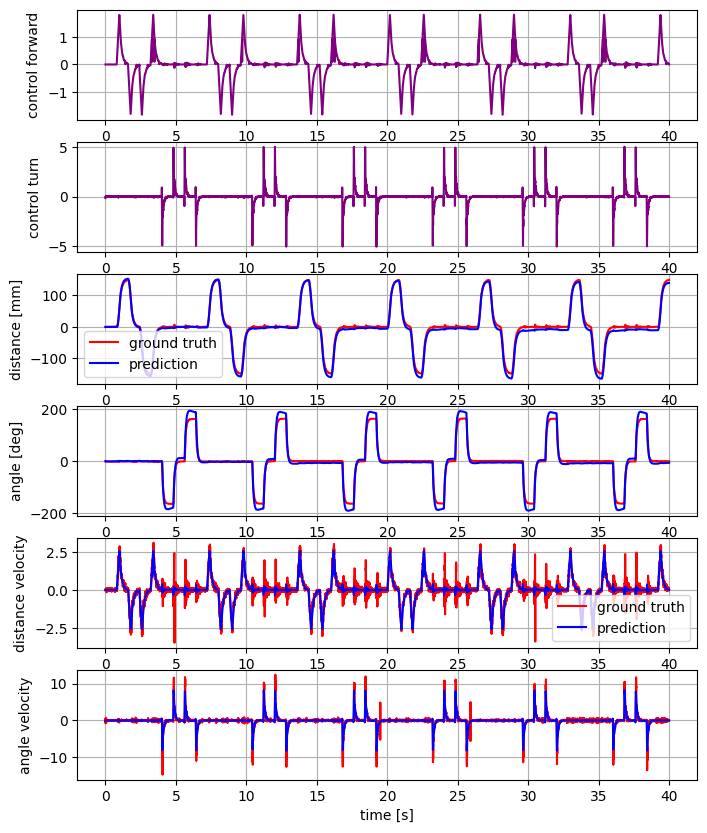

In [27]:
#model verification
#set same inputs and initial conditions

ds = LibsControl.DynamicalSystemDiscrete(a_est, b_est, c_est)    

x_initial = numpy.expand_dims(x_ref[0], axis=0).T
ds.reset(x_initial)

x_hat_result = []

for n in range(n_steps):

    u = u_result[n, :]
    u = numpy.expand_dims(u, axis=0).T

    x, y = ds.forward_state(u)

    x_hat_result.append(x[:, 0])

x_hat_result = numpy.array(x_hat_result)


#plot results
plot_results(t_result, u_result, x_ref, x_hat_result, 0, 10000)


In [28]:
#controller synthetis

#create loss weighting matrices (diagonal)
#q = numpy.diag([ 10**-7, 0.5*(10**-3), 0.0, 0.0] )
#q = numpy.diag([ 10**-6, 0.5*(10**-3), 0.0, 0.0] )
q = numpy.diag([ 1.0, 1.0, 0.0, 0.0] )
r = numpy.diag( [10**7, 10**4])  



#solve MPC controller 
control_horizon = 8
prediction_horizon = 32
mpc = LibsControl.MPC(a_est, b_est, q, r, control_horizon, prediction_horizon)

print("controller")
print("phi    = \n", mpc.phi.shape, "\n")
print("omega  = \n", mpc.omega.shape, "\n")
print("sigma  = \n", mpc.sigma.shape, "\n")
print("\n\n")


controller
phi    = 
 (128, 4) 

omega  = 
 (128, 2) 

sigma  = 
 (2, 128) 






<Figure size 640x480 with 0 Axes>

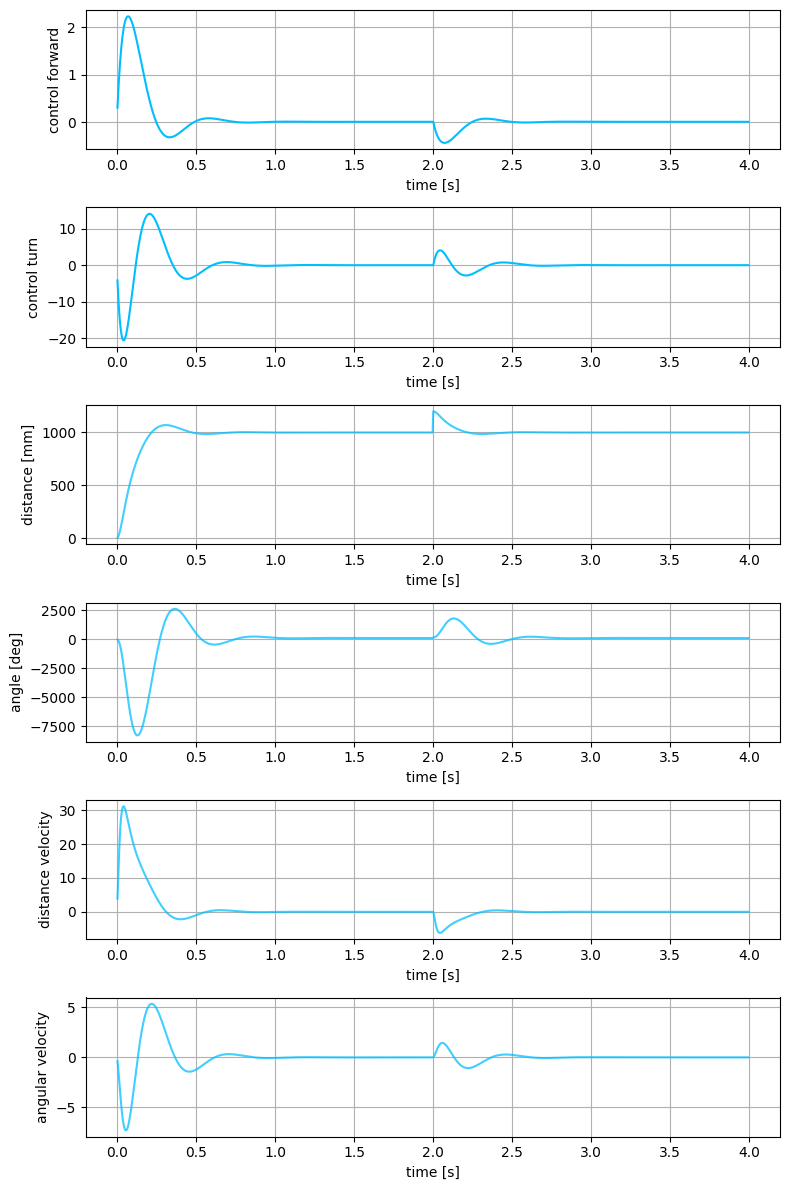

In [29]:
#process simulation

n_max = int(4.0/dt)

#required output, 1 meter, 100degrees
xr = numpy.array([[1000.0, 100.0*numpy.pi/180.0, 0.0, 0.0]]).T

#plant state
x = numpy.zeros((a_est.shape[0], 1))

#action result
u = numpy.zeros((b_est.shape[1], 1))


#result log
t_result = [] 
u_result = []
x_result = []


for n in range(n_max):
    #compute controller output
    u = mpc.forward(xr, x, u)

    #disturbance
    '''
    if n > n_max//2:
        u[0, :]+= 50
        u[1, :]+= 100
    '''

    if n == n_max//2:
        x[0, 0]+= 200
        x[1, 0]+= 1

    
    #compute plant output
    y = c_est@x
    x = a_est@x + b_est@u
    
    t_result.append(n*dt)
    u_result.append(u[:, 0].copy())
    x_result.append(x[:, 0].copy())

    
    
t_result = numpy.array(t_result)
u_result = numpy.array(u_result)
x_result = numpy.array(x_result)


du_result = x_result[1:, :] - x_result[0:-1, :]

#plot results
#convert angle to degrees
x_result[:, 1]*= 180.0/numpy.pi 

LibsControl.plot_closed_loop_response(t_result, u_result, x_result, x_hat = None, file_name = "mpc_controller_output.png", u_labels = ["control forward", "control turn"], x_labels = ["distance [mm]", "angle [deg]", "distance velocity", "angular velocity"])


#plt.plot(du_result[:, 0], label="du[0] change")
#plt.plot(du_result[:, 1], label="du[1] change")
#plt.show()



In [30]:
#print c-like arrays
print(matrix_to_c("a",  a_est))
print(matrix_to_c("b",  b_est))
print(matrix_to_c("c",  c_est))
print(matrix_to_c("phi",  mpc.phi)) 
print(matrix_to_c("omega", mpc.omega))
print(matrix_to_c("sigma",  mpc.sigma))




float a[] = {
		1.0, -0.00091410923, 0.62815064, 1.5574883, 
		6.5819265e-08, 1.0, -0.00082464435, 0.77049845, 
		-4.630251e-05, -0.00090979744, 0.6281297, 1.561936, 
		9.1242434e-08, -0.00011871641, -0.00090523565, 0.7712711 };

float b[] = {
		5.2099957, -0.5465586, 
		0.011610654, 0.0891618, 
		5.210089, -0.5487993, 
		0.012767176, 0.0889518 };

float c[] = {
		1.0, 0.0, 0.0, 0.0, 
		0.0, 1.0, 0.0, 0.0, 
		0.0, 0.0, 1.0, 0.0, 
		0.0, 0.0, 0.0, 1.0 };

float phi[] = {
		1.0, -0.00091410923, 0.62815064, 1.5574883, 
		6.5819265e-08, 1.0, -0.00082464435, 0.77049845, 
		-4.630251e-05, -0.00090979744, 0.6281297, 1.561936, 
		9.1242434e-08, -0.00011871641, -0.00090523565, 0.7712711, 
		0.99997103, -0.0025846076, 1.0213015, 3.7391608, 
		2.401238e-07, 0.9999093, -0.0020400693, 1.3634738, 
		-7.524403e-05, -0.0016666533, 0.3931047, 2.1850014, 
		2.0352196e-07, -0.00020945545, -0.0012666322, 0.59335387, 
		0.9999241, -0.004871768, 1.2662596, 6.0345664, 
		5.248041e-07, 0.99974924, -0.00334011